In [1]:
import os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
# from matplotlib import font_manager as fm, rcParams
import seaborn as sns
import dexplot as dxp #https://www.dexplo.org/dexplot/

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

allBounty = pd.read_csv("gitcoin_dataset_5.csv")
activity_coll = pd.read_csv("activities_collection_3.csv")
bounty_changed = pd.read_csv("changedBounty2.csv")

In [2]:
#Cleansing data------------------------------------------------------------------------------------------------

# activity_coll.drop('duration_worker_applied_to_worker_approved',axis='columns', inplace=True)
#allBounty.drop('is_paid',axis='columns', inplace=True)

#fill-in 'numerical values' with their median
allBounty['value_in_eth'].fillna(float(allBounty['value_in_eth'].median()), inplace = True)
allBounty['value_in_usdt_now'].fillna(float(allBounty['value_in_usdt_now'].median()), inplace = True)
allBounty['value_in_usdt'].fillna(float(allBounty['value_in_usdt'].median()), inplace = True)
allBounty['token_value_in_usdt'].fillna(float(allBounty['token_value_in_usdt'].median()), inplace = True)

#fill-in 'categorical values' with "NA" (except for github_issue_number)
allBounty['title'].fillna("NA", inplace = True)
allBounty['funder_last_messaged_on'].fillna("NA", inplace = True)
allBounty['is_reserved'].fillna("NA", inplace = True)
allBounty['canceled_bounty_reason'].fillna("NA", inplace = True) #This is interseting
allBounty['reserved_for_user_handle'].fillna("NA", inplace = True)
allBounty['attached_job_description'].fillna("NA", inplace = True)
allBounty['canceled_on'].fillna("NA", inplace = True) #This is interseting: may be use web3_create - cancel_on
allBounty['funding_organisation'].fillna("NA", inplace = True) #This is interseting:384 distinct org
allBounty['featuring_date'].fillna("NA", inplace = True)
allBounty['fulfillment_accepted_on'].fillna("NA", inplace = True)#This is interseting
allBounty['fulfillment_submitted_on'].fillna("NA", inplace = True)#This is interseting
allBounty['fulfillment_started_on'].fillna("NA", inplace = True)#This is interseting
allBounty['keywords'].fillna("NA", inplace = True) #This is interseting
allBounty['bounty_owner_name'].fillna("NA", inplace = True)
allBounty['github_issue_state'].fillna("NA", inplace = True) #This is interseting
allBounty['bounty_owner_github_username'].fillna("NA", inplace = True)
allBounty['bounty_owner_email'].fillna("NA", inplace = True)
allBounty['github_issue_number'].fillna(0, inplace = True) #github_issue_state is interesting
allBounty['github_repo_name'].fillna("NA", inplace = True)
allBounty['org_name'].fillna("NA", inplace = True)
allBounty['github_org_name'].fillna("NA", inplace = True)

allBounty.loc[allBounty['bounty_type'] == "0", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Andere", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Funkcja", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "æ¹å", 'bounty_type'] = "Other"
allBounty['bounty_type'].fillna("NA", inplace = True)

allBounty.loc[allBounty['experience_level'] == "0", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Mittlere", 'experience_level'] = "Intermediate"
allBounty.loc[allBounty['experience_level'] == "åå¿è", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Pośredni", 'experience_level'] = "Intermediate"
allBounty['experience_level'].fillna("NA", inplace = True)

allBounty.loc[allBounty['project_length'] == "0", 'project_length'] = "Unknown"
allBounty.loc[allBounty['project_length'] == "Tage", 'project_length'] = "Days"
allBounty.loc[allBounty['project_length'] == "Miesięcy", 'project_length'] = "Months"
allBounty['project_length'].fillna("NA", inplace = True)

#merge two dataframe together--------------------------------------------------------------------------------------
outer_merged = pd.merge(allBounty, activity_coll, how="outer", on=["pk"])
outer_merged = pd.merge(outer_merged, bounty_changed, how="outer", on=["pk"])

outer_merged['increased_bounty_times'].fillna(0, inplace = True)
outer_merged['changed_bounty_value'].fillna(0, inplace = True)

outer_merged['firstAct_activity_type'].fillna("NA", inplace = True)
outer_merged['lastAct_activity_type'].fillna("NA", inplace = True)

outer_merged['duration_create_to_done'].fillna(0, inplace = True)
outer_merged['duration_create_to_firstAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_killed'].fillna(0, inplace = True)
outer_merged['duration_create_to_lastAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_new_bounty'].fillna(0, inplace = True)
outer_merged['duration_create_to_start'].fillna(0, inplace = True)
outer_merged['duration_create_to_stop'].fillna(0, inplace = True)
outer_merged['duration_create_to_submitted'].fillna(0, inplace = True)
outer_merged['duration_create_to_worker_applied'].fillna(0, inplace = True)
outer_merged['number_of_user_in_activities'].fillna(0, inplace = True)

# deal with outliers
columns_to_delete_outliers = ['duration_create_to_expire', 'duration_create_to_done', 'duration_create_to_submitted',
                             'github_comments', 'description_length', 'value_in_eth', 'value_in_usdt']

for x in columns_to_delete_outliers:
    Q1 = outer_merged[x].quantile(0.25)
    Q2 = outer_merged[x].quantile(0.50)
    Q3 = outer_merged[x].quantile(0.75)
    IQR = Q3 - Q1
    outer_merged[x] = np.where((outer_merged[x] > (Q3 + 1.5*IQR)) | (outer_merged[x]< (Q1-1.5*IQR)), Q2, outer_merged[x])

# Delete outliers and negative values for 'duration_create_to_new_bounty'
Q1 = outer_merged['duration_create_to_new_bounty'].quantile(0.25)
Q2 = outer_merged['duration_create_to_new_bounty'].quantile(0.50)
Q3 = outer_merged['duration_create_to_new_bounty'].quantile(0.75)
IQR = Q3 - Q1
outer_merged['duration_create_to_new_bounty'] = np.where((outer_merged['duration_create_to_new_bounty'] > (Q3 + 1.5*IQR)) | (outer_merged['duration_create_to_new_bounty']< 0), Q2, outer_merged['duration_create_to_new_bounty'])  

# Delete negative value for 'duration_create_to_worker_applied'
Q1_2 = outer_merged['duration_create_to_worker_applied'].quantile(0.25)
Q2_2 = outer_merged['duration_create_to_worker_applied'].quantile(0.50)
Q3_2 = outer_merged['duration_create_to_worker_applied'].quantile(0.75)
IQR_2 = Q3_2 - Q1_2
outer_merged['duration_create_to_worker_applied'] = np.where((outer_merged['duration_create_to_worker_applied'] < 0), Q2_2, outer_merged['duration_create_to_worker_applied'])

Feature          1851
NA               1015
Improvement       679
Other             346
Bug               333
Documentation     224
Security           70
Design             46
Code Review        20
Name: bounty_type, dtype: int64

<Figure size 864x720 with 0 Axes>

Text(0, 0.5, 'Bounty types')

Text(0.5, 0, 'Number of issues')

Text(840, -0.10000000000000003, '820')

Text(402, 0.9000000000000001, '382')

Text(288, 1.9000000000000001, '268')

Text(168, 2.8999999999999995, '148')

Text(187, 3.8999999999999995, '167')

Text(82, 4.8999999999999995, '62')

Text(64, 5.8999999999999995, '44')

Text(41, 6.8999999999999995, '21')

Text(30, 7.8999999999999995, '10')

Text(1051, 0.29999999999999993, '1031')

Text(653, 1.2999999999999998, '633')

Text(431, 2.3, '411')

Text(218, 3.3, '198')

Text(186, 4.3, '166')

Text(182, 5.3, '162')

Text(46, 6.3, '26')

Text(45, 7.3, '25')

Text(30, 8.299999999999999, '10')

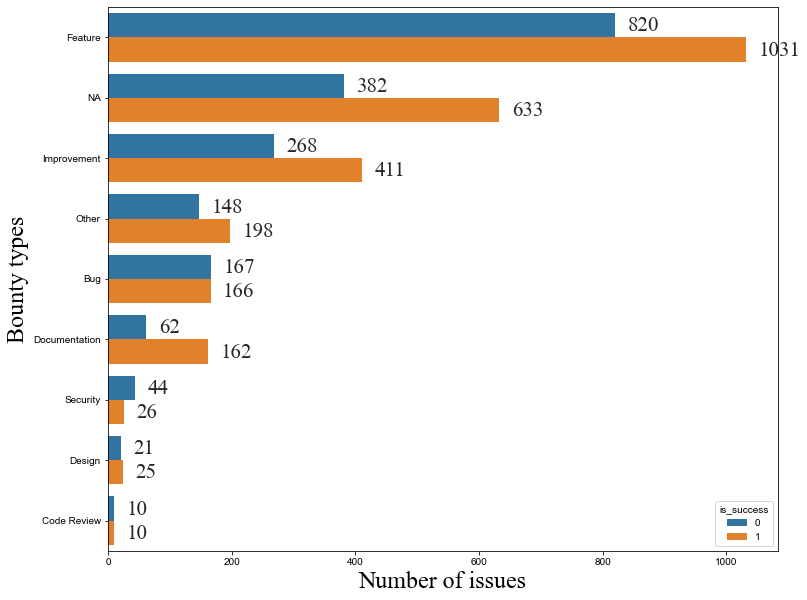

In [3]:
# Bounty types & is_success
outer_merged['bounty_type'].value_counts()

plt.figure(figsize=(12,10))
ax = sns.countplot(y='bounty_type', data = outer_merged, hue='is_success', order=outer_merged['bounty_type'].value_counts().index[::1])
ax.set_ylabel("Bounty types", font="Times New Roman", fontsize=24)
ax.set_xlabel("Number of issues", font="Times New Roman", fontsize=24)
sns.set(font_scale=1.75, font="Times New Roman")

for p in ax.patches:
    x = p.get_x() + p.get_width() + 20
    y = p.get_y() + 0.3
    ax.annotate('{:1}'.format(p.get_width()), (x,y))

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .4)
# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/1-1_bounty_type.png', dpi = 600)
plt.show()

<Figure size 864x720 with 0 Axes>

Text(0.5, 0, 'Number of issues')

Text(0, 0.5, 'Project lengths')

Text(984, -0.10000000000000003, '964')

Text(526, 0.9000000000000001, '506')

Text(219, 1.9000000000000001, '199')

Text(144, 2.8999999999999995, '124')

Text(132, 3.8999999999999995, '112')

Text(37, 4.8999999999999995, '17')

Text(1305, 0.29999999999999993, '1285')

Text(678, 1.2999999999999998, '658')

Text(357, 2.3, '337')

Text(233, 3.3, '213')

Text(184, 4.3, '164')

Text(25, 5.3, '5')

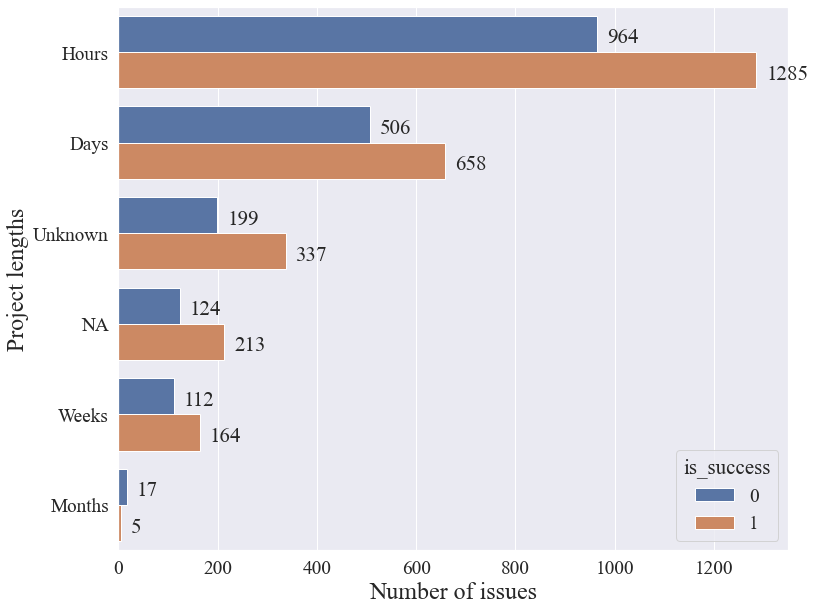

In [4]:
# Project Lengths & is_success

plt.figure(figsize=(12,10))
ax = sns.countplot(y='project_length', data = outer_merged, hue='is_success', order=outer_merged['project_length'].value_counts().index[::1])
ax.set_xlabel("Number of issues", font="Times New Roman", fontsize=24)
ax.set_ylabel("Project lengths", font="Times New Roman", fontsize=24)
sns.set(font_scale=1.75, font="Times New Roman")

for p in ax.patches:
    x = p.get_x() + p.get_width() + 20
    y = p.get_y() + 0.3
    ax.annotate('{:1}'.format(p.get_width()), (x,y))

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .4)
# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/1-2_project_length.png', dpi = 600)
plt.show()

<Figure size 720x576 with 0 Axes>

Text(0.5, 0, 'Number of issues')

Text(0, 0.5, 'Experience levels')

Text(1030, -0.10000000000000003, '1010')

Text(373, 0.9000000000000001, '353')

Text(298, 1.9000000000000001, '278')

Text(292, 2.8999999999999995, '272')

Text(29, 3.8999999999999995, '9')

Text(1425, 0.29999999999999993, '1405')

Text(526, 1.2999999999999998, '506')

Text(521, 2.3, '501')

Text(263, 3.3, '243')

Text(27, 4.3, '7')

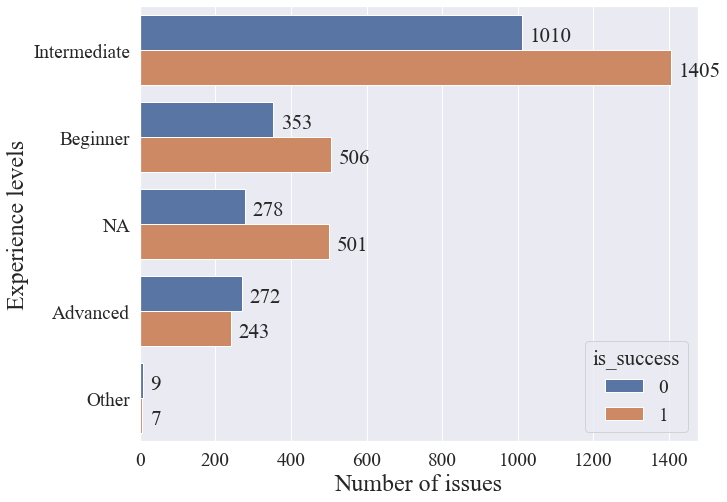

In [5]:
# Experience Levels & is_success

plt.figure(figsize=(10,8))
ax = sns.countplot(y='experience_level', data = outer_merged, hue='is_success',order=outer_merged['experience_level'].value_counts().index[::1])
ax.set_xlabel("Number of issues", font="Times New Roman", fontsize=24)
ax.set_ylabel("Experience levels", font="Times New Roman", fontsize=24)
sns.set(font_scale=1.75, font="Times New Roman")

for p in ax.patches:
    x = p.get_x() + p.get_width() + 20
    y = p.get_y() + 0.3
    ax.annotate('{:1}'.format(p.get_width()), (x,y))

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .4)

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/1-3_experience_level.png', dpi = 600)
plt.show()

<Figure size 720x432 with 0 Axes>

Text(0, 0.5, 'Project types')

Text(0.5, 0, 'Number of issues')

Text(1416, -0.125, '1386')

Text(321, 0.8750000000000001, '291')

Text(275, 1.875, '245')

Text(1951, 0.275, '1921')

Text(601, 1.275, '571')

Text(200, 2.275, '170')

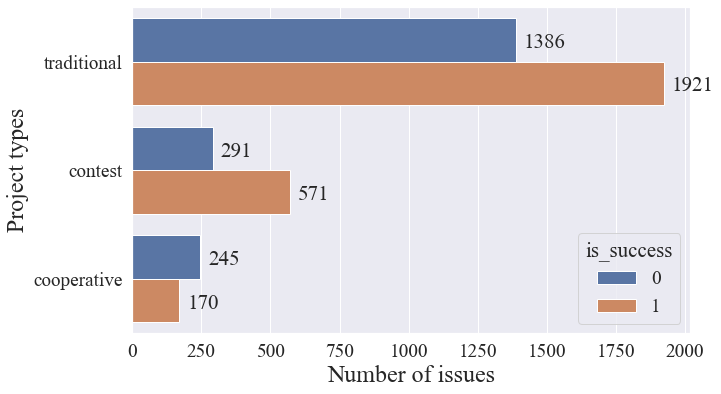

In [6]:
# Project Types & is_success

outer_merged['project_type'].fillna("NA", inplace = True)

plt.figure(figsize=(10,6))

ax = sns.countplot(y='project_type', data = outer_merged, hue='is_success', order=outer_merged['project_type'].value_counts().index[::1])
ax.set_ylabel("Project types", fontname="Times New Roman", fontsize=24)
ax.set_xlabel("Number of issues", fontname="Times New Roman", fontsize=24)
sns.set(font_scale=1.75, font="Times New Roman")

for p in ax.patches:
    x = p.get_x() + p.get_width() + 30
    y = p.get_y() + 0.275
    ax.annotate('{:1}'.format(p.get_width()), (x,y))

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .4)

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/1-4_project_type.png', dpi = 600)
plt.show()

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Number of issues')

Text(0, 0.5, 'Number of comments')

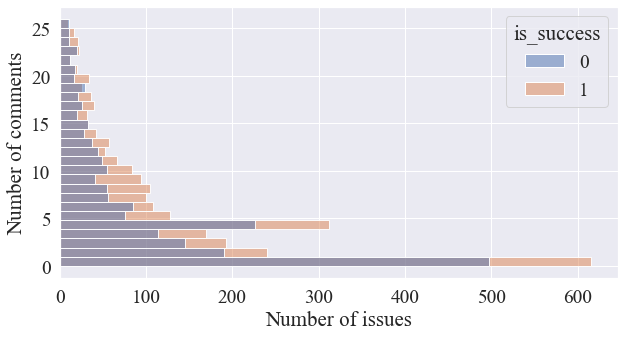

In [7]:
# GitHub Comments & is_success

plt.figure(figsize=(10,5))
ax = sns.histplot(data=outer_merged, y="github_comments", hue='is_success')

plt.xlabel('Number of issues')
plt.ylabel('Number of comments')

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/1-5_github_comments.png', dpi = 600)

<Figure size 720x360 with 0 Axes>

<AxesSubplot:xlabel='Count', ylabel='description_length'>

Text(0.5, 0, 'Number of issues')

Text(0, 0.5, 'Number of characters')

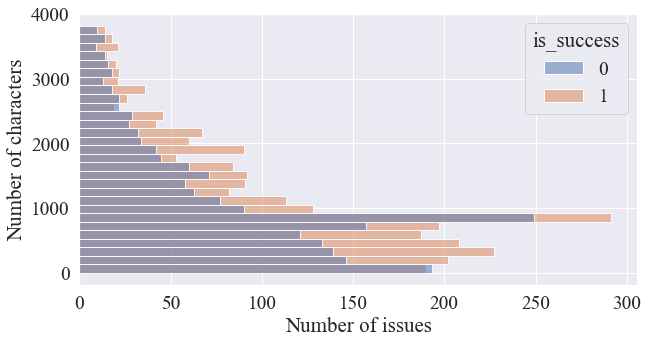

In [8]:
# Length of Description & is_success

plt.figure(figsize=(10,5))
sns.histplot(data=outer_merged, y="description_length", hue='is_success')
plt.xlabel('Number of issues')
plt.ylabel('Number of characters')

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/1-6_description_length.png', dpi = 600)

ETH     2416
DAI     1208
SAI      435
USDC      66
MYB       25
        ... 
ONE        1
NTV        1
JAMM       1
DATA       1
ALEX       1
Name: token_name, Length: 84, dtype: int64

<Figure size 720x576 with 0 Axes>

Text(0.5, 0, 'Number of issues')

Text(0, 0.5, 'Token names')

Text(1094, -0.10000000000000003, '1074')

Text(423, 0.9000000000000001, '403')

Text(166, 1.9000000000000001, '146')

Text(57, 2.8999999999999995, '37')

Text(32, 3.8999999999999995, '12')

Text(1362, 0.29999999999999993, '1342')

Text(825, 1.2999999999999998, '805')

Text(309, 2.3, '289')

Text(49, 3.3, '29')

Text(33, 4.3, '13')

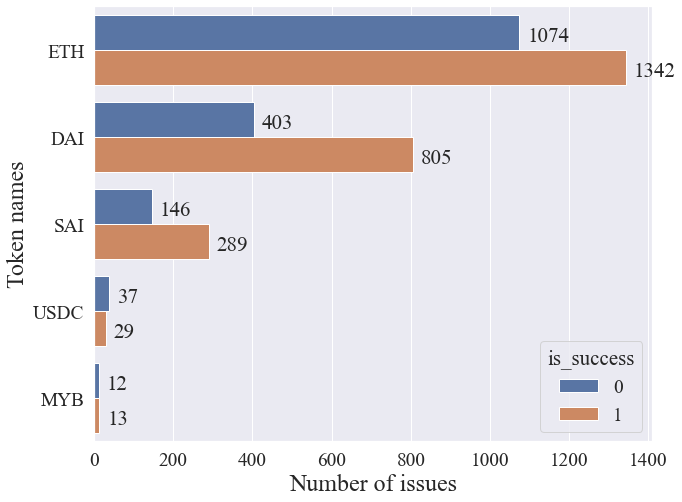

In [9]:
# Token names & is_success
outer_merged['token_name'].value_counts()

plt.figure(figsize=(10,8))
ax = sns.countplot(y='token_name',data = outer_merged, 
                    order = outer_merged['token_name'].value_counts().index[:5:1], hue='is_success')
ax.set_xlabel("Number of issues", font="Times New Roman", fontsize=24)
ax.set_ylabel("Token names", font="Times New Roman", fontsize=24)
sns.set(font_scale=1.75, font="Times New Roman")


for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")

for p in ax.patches:
    x = p.get_x() + p.get_width() + 20
    y = p.get_y() + 0.3
    ax.annotate('{:1}'.format(p.get_width()), (x,y))

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .4)

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/2-5_token_name.png', dpi = 600)
plt.show()

<Figure size 720x360 with 0 Axes>

<AxesSubplot:xlabel='Count', ylabel='value_in_eth'>

Text(0.5, 0, 'Number of issues')

Text(0, 0.5, 'ETH value')

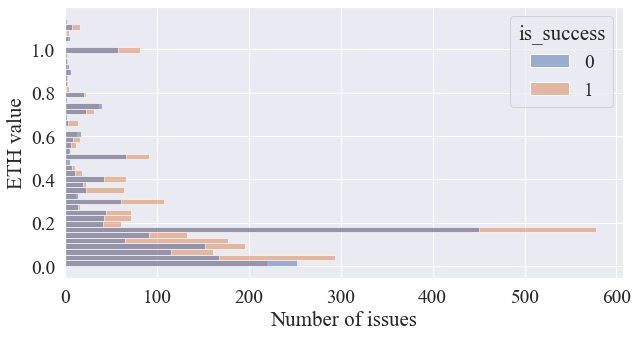

In [10]:
# ETH values & is_success

plt.figure(figsize=(10,5))
sns.histplot(data=outer_merged, y="value_in_eth", hue='is_success')
plt.xlabel('Number of issues')
plt.ylabel('ETH value')

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/2-1_value_in_eth.png', dpi = 600)

<Figure size 720x360 with 0 Axes>

<AxesSubplot:xlabel='Count', ylabel='value_in_usdt'>

Text(0.5, 0, 'Number of issues')

Text(0, 0.5, 'USD value')

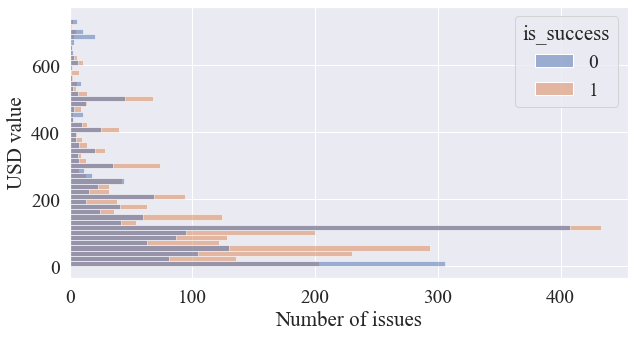

In [11]:
# USD values & is_success

plt.figure(figsize=(10,5))
sns.histplot(data=outer_merged, y="value_in_usdt", hue='is_success')
plt.xlabel('Number of issues')
plt.ylabel('USD value')

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/2-2_value_in_usdt.png', dpi = 600)

<Figure size 720x360 with 0 Axes>

Text(0, 0.5, '')

Text(0.5, 0, 'Number of issues')

Text(1388, 0.19999999999999996, '1348')

Text(1090, 1.2, '1050')

Text(596, 2.2, '556')

Text(564, 3.2, '524')

Text(407, 4.2, '367')

Text(313, 5.199999999999999, '273')

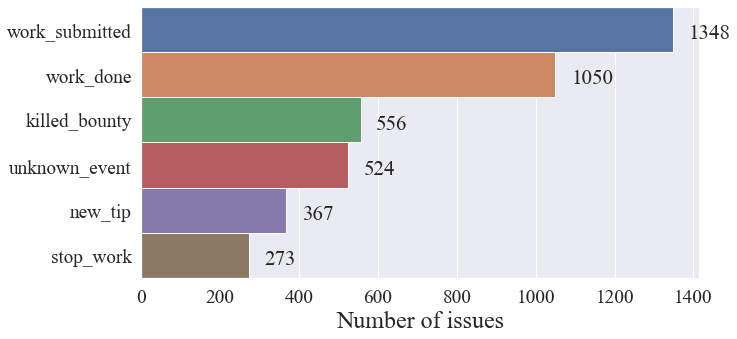

In [12]:
# last activity types

plt.figure(figsize=(10,5))

ax = sns.countplot(y='lastAct_activity_type',data = outer_merged,  
                   order = outer_merged['lastAct_activity_type'].value_counts().index[:6])
# ax.set_ylabel("The last activity occurred in an issue", fontname="Times New Roman", fontsize=24)
ax.set_ylabel("", fontname="Times New Roman", fontsize=24)
ax.set_xlabel("Number of issues", fontname="Times New Roman", fontsize=24)
sns.set(font_scale=1.75, font="Times New Roman")

# The number of each bar at the right side
for p in ax.patches:
    x = p.get_x() + p.get_width() + 40
    y = p.get_y() + 0.6
    ax.annotate('{:.0f}'.format(p.get_width()), (x,y))

# The bar width -- Not affect the position of numbers
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, 1)

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/4-6_lastAct_activity_type.png', dpi = 600)
plt.show()

<AxesSubplot:>

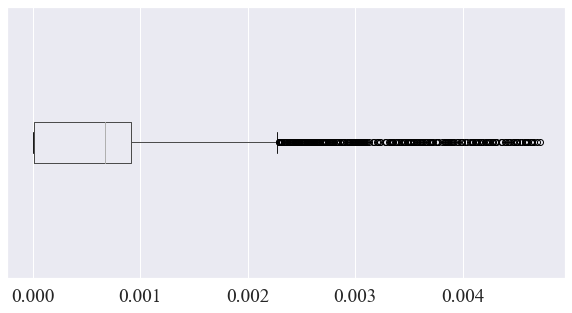

In [13]:
# Duration from issue creation until first bounty proposal

sns.set(font_scale=1.75, font="Times New Roman")

outer_merged.boxplot(column=['duration_create_to_new_bounty'], vert = 0, figsize=(10,5))
plt.gca().axes.get_yaxis().set_visible(False)

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/box_newBT.png', dpi = 600)

<AxesSubplot:>

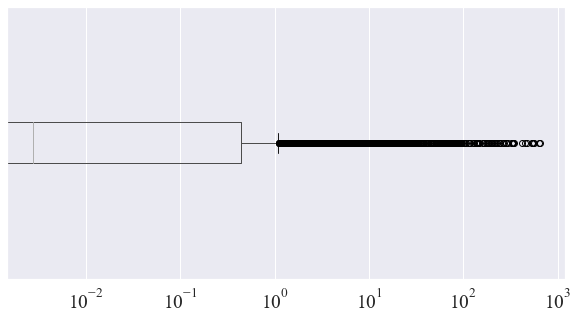

In [14]:
# Duration from issue creation until a contributor applying

sns.set(font_scale=1.75, font="Times New Roman") 

outer_merged.boxplot(column=['duration_create_to_worker_applied'], vert = 0, figsize=(10,5))
plt.xscale("log")
plt.gca().axes.get_yaxis().set_visible(False)

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/box_workerApp.png', dpi = 600)

<AxesSubplot:>

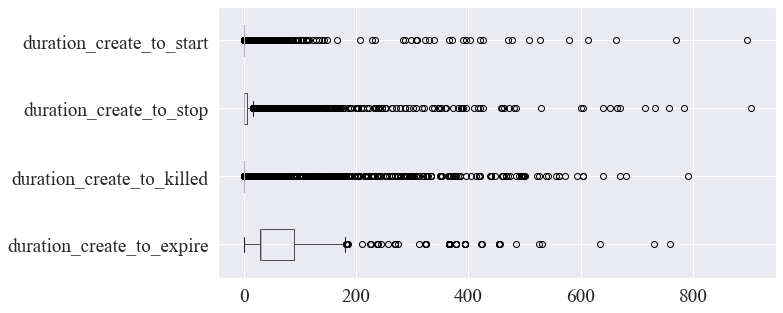

In [15]:
# The duration from issue creation until work is started/stopped/killed, and issue expiration

sns.set(font_scale=1.75, font="Times New Roman")

outer_merged.boxplot(column=['duration_create_to_expire','duration_create_to_killed',
                             'duration_create_to_stop','duration_create_to_start'], vert = 0, figsize=(10,5))

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/box_start_stop_killed_expire.png', dpi = 600)

<AxesSubplot:>

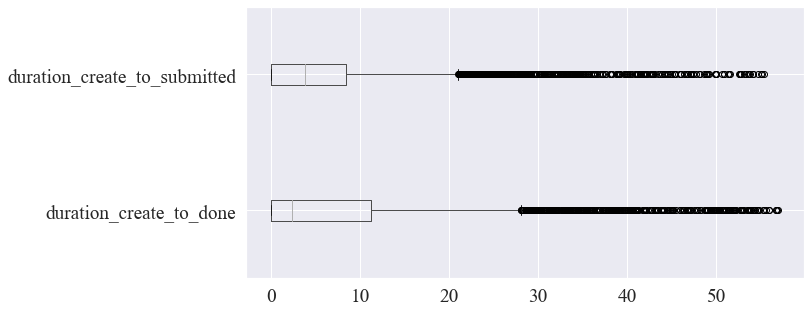

In [16]:
# The duration from issue creation until work is done and submitted

sns.set(font_scale=1.75, font="Times New Roman")

outer_merged.boxplot(column=['duration_create_to_done','duration_create_to_submitted'], vert = 0, figsize=(10,5))

# plt.savefig('D:/Pann/Year 4/SP2020/Semester 2/Document/Pic2/Final/3-done-submitted.png', dpi = 600)